# Projet 4 : Segmentez des clients d'un site e-commerce

Pour ce projet on dispose de données des utilisateurs du site de e-commerce OLIST. Le but de ce projet est de proposer une segmentation des clients qui pourra être utilisée par l'équipe marketing à des fins de communication. D'un point de vue machine learning l'objectif est d'utiliser un algorithme non supervisé afin de faire des groupes de clients. Il faut pouvoir évaluer cette segmentation avec des indicateurs. Il faut également que cette segmentation soit utilisable par l'équipe de marketing. 

Les données sont stockées sur kaggle : https://www.kaggle.com/olistbr/brazilian-ecommerce

## Notebook 2 : Segmentation

* Clustering : K-Means
* Coefficient de silhouette
* ARI : Adjusted Rand index
* Stabilité à l'initialisation
* Stabilité temporelle

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score, adjusted_rand_score

plt.rcParams.update({'font.size': 12})

### Clustering : K-Means

Le but du clustering est de faire des groupes de points ayant des similitudes. Pour cela on utilise un algorithme non supervisé c'est-à-dire que l'algorithme n'est pas entraîné à faire de la prédiction, mais il essaie de regrouper les données qui se ressemblent. 

Dans cette étude nous allons utiliser l'algorithme K-Means qui est itératif. 

<img src="KMeans.gif" width="308" align="center">

Le fonctionnement de cet algorithme est relativement simple :
* On définit un nombre de cluster
* On place des centroid aléatoirement
* Puis pour chaque itération :
    * Pour chaque point on détermine le centroid le plus proche
    * Pour chaque cluster on détermine le barycentre

Afin d'évaluer la qualité d'une segmentation il faut regarder plusieurs choses :
* l'homogénéité des cluster : on ne veut pas avoir un cluster contenant 5 % des données et un autre contenant 95 % des données. Dans l'idéal les clusters ont un nombre de points similaires. Pour cela on peut simplement regarder le nombre de point dans chaque cluster.
* l'éloignement entre les clusters : dans l'idéal on cherche à avoir des clusters les plus éloignés les uns des autres. En d'autres termes il faut s'intéresser à la distance inter-cluster.
* la densité de chaque cluster : dans l'idéal on souhaite avoir des cluster dans lesquels les points sont proches par rapport aux autres. En d'autres termes il faut étudier la distance intra-cluster.

Un moyen de s'intéresser à tous ces aspects est de calculer le coefficient silhouette.

### Coefficient de silhouette

Le coefficient de silhouette (ou silhouette score en anglais) est un indicateur intéressant car il compare la distance intra-cluster par rappport à la distance inter-cluster. Ce coefficient se calcule pour chaque point.

$$ \text{coefficient de silhouette} = \frac{\text{(distance inter-cluster) - (distance intra-cluster)}}{\text{max(distance inter-cluster, distance intra-cluster)}}$$ 

Le coefficient silhouette ne peut donc pas être supérieur à 1. 

Dans l'idéal on souhaite un coefficient silhouette proche de 1 car cela signifie que le point est proche des points de son cluster et éloigné des points des autres clusters. 

Le coefficient peut être inférieur à 0. Cela signifie que le point est possiblement dans le mauvais cluster car il est plus proche en terme de distance des points d'un autre cluster que des points de son propre cluster.

Nous allons faire du clustering en utilisant l'algorithme K-Means pour un nombre différent de cluster. Afin d'évaluer la pertinance de la segmentation nous allons calculer le coefficient silhouette et faire des radar plot pour représenter l'élément moyen de chaque cluster. Il nous faut donc plusieurs fonctions :
* clusterAnalysis : Segmentation pour différents nombre de cluster + coefficient silhouette + graphs
* radarPlot : Segmentation + graphs radar pour différents nombre de cluster


In [2]:
def clusterAnalysis(X, range_n_clusters):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.

        model_clustering = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = model_clustering.fit_predict(X_scaled)

        model_PCA = PCA(n_components=2)
        X_2dim = model_PCA.fit_transform(X_scaled)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X_scaled, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X_scaled, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X_2dim[:, 0], X_2dim[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = model_PCA.transform(model_clustering.cluster_centers_)
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

    plt.show()

In [3]:
def radarPlot(X, range_n_clusters):
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(data=scaler.fit_transform(X), columns=X.columns)

    for n_clusters in range_n_clusters:
        model_clustering = KMeans(n_clusters=n_clusters)
        X_clusters = model_clustering.fit_transform(X_scaled)
        y = model_clustering.labels_

        nb_radar = len(np.unique(y))
        variables = X_scaled.columns
        num_vars = len(variables)
        angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
        angles += angles[:1]

        fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
        ax.set_title(str(n_clusters) + ' clusters')
        plt.xticks(angles[:-1],variables)

        for i in range(nb_radar):
            boolean_index = y == i
            cluster = X_scaled.loc[boolean_index,variables]
            values = cluster.mean()/X_scaled.max()
            values = values.tolist()
            values += values[:1]
            ax.plot(angles, values, linewidth=1, label= 'clients ' + str(i))
            ax.fill(angles, values, alpha=0.25)

In [4]:
data = pd.read_csv('data/X_shape0_full.csv', sep=';')
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

### Totalité des variables

Dans un premier temps on sélectionne l'ensemble des données afin de voir si l'on obtient une segmentation cohérente. Pour déterminer cela nous allons utiliser le coefficient silhouette et les graphs radar.

In [5]:
X = data.copy()

For n_clusters = 2 The average silhouette_score is : 0.15746566342382584
For n_clusters = 3 The average silhouette_score is : 0.15964147101906825
For n_clusters = 4 The average silhouette_score is : 0.1617170662740041
For n_clusters = 5 The average silhouette_score is : 0.12207317104424562
For n_clusters = 6 The average silhouette_score is : 0.13678523977755333
For n_clusters = 7 The average silhouette_score is : 0.1599788912539042
For n_clusters = 8 The average silhouette_score is : 0.1691888450187816


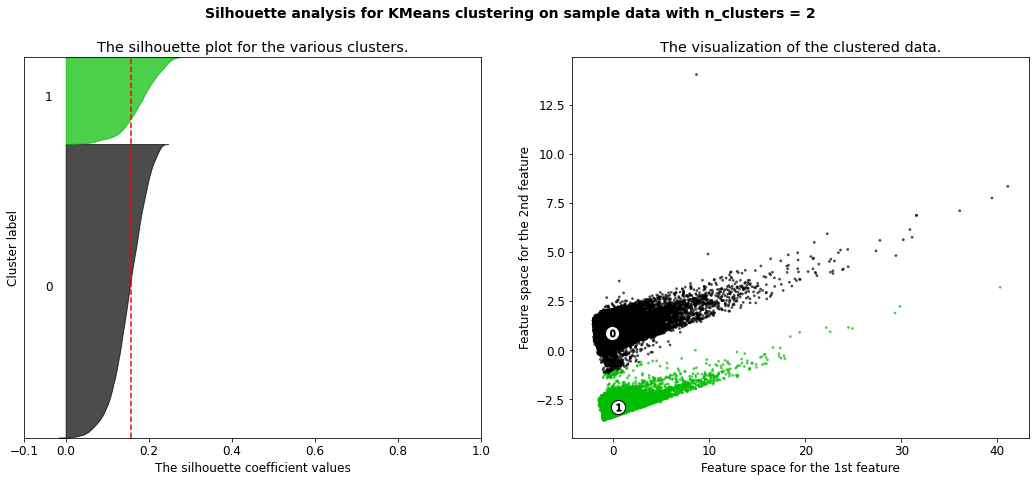

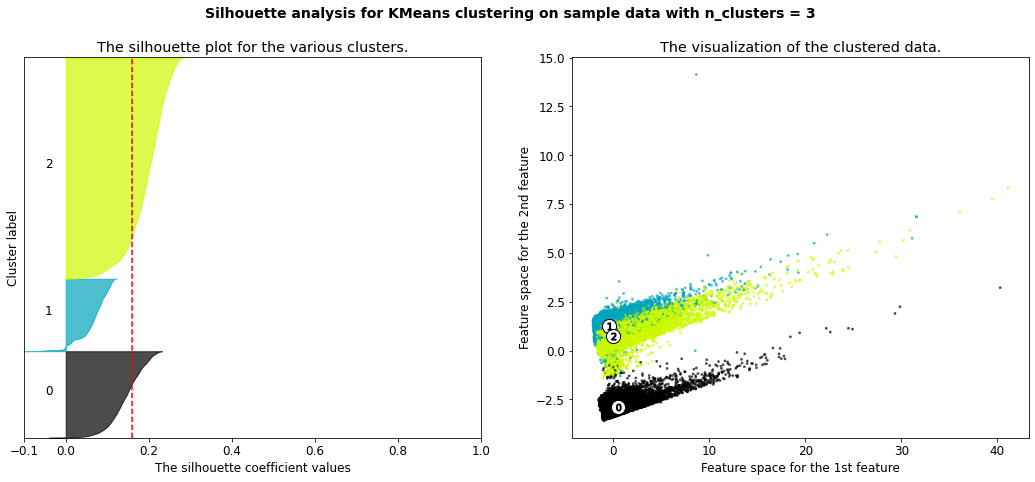

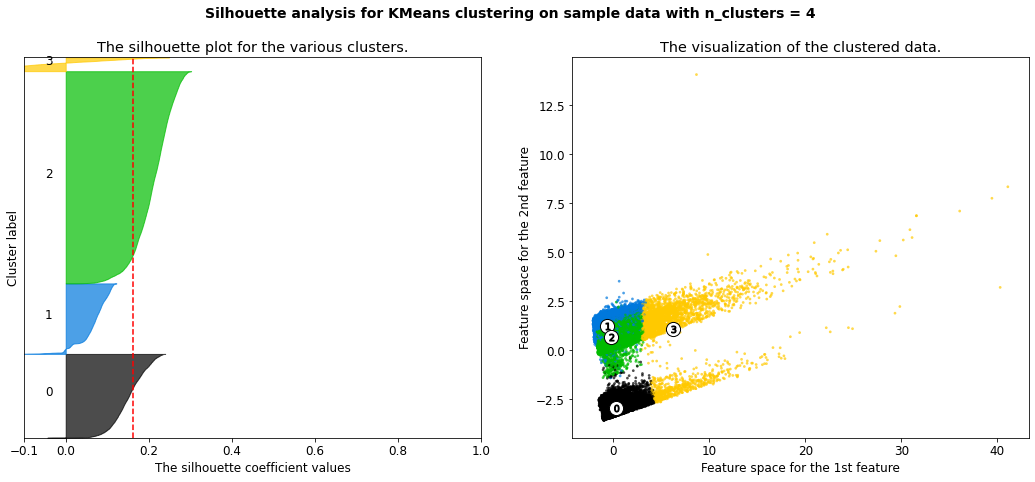

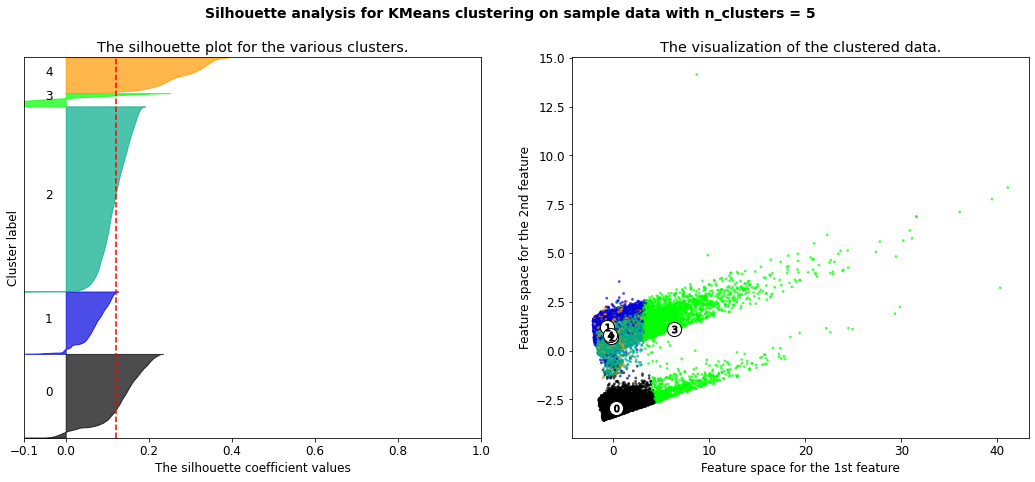

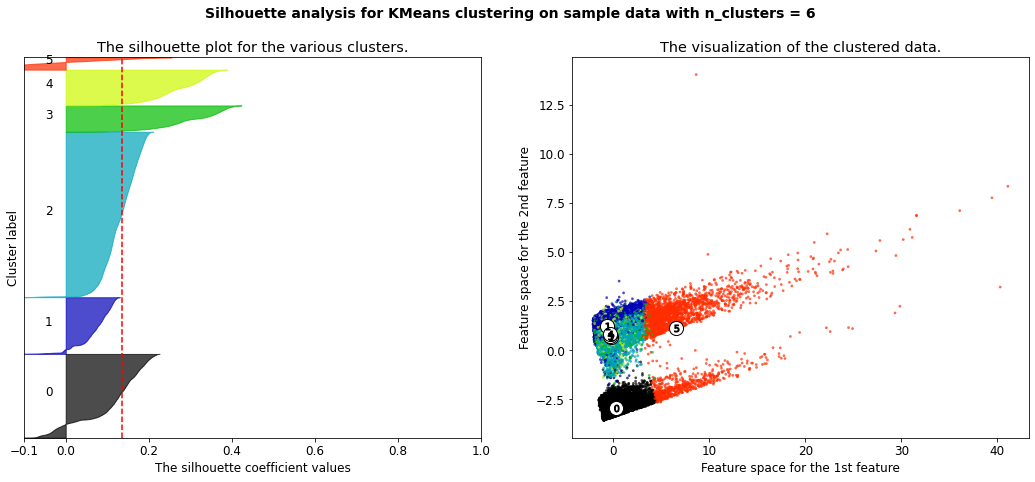

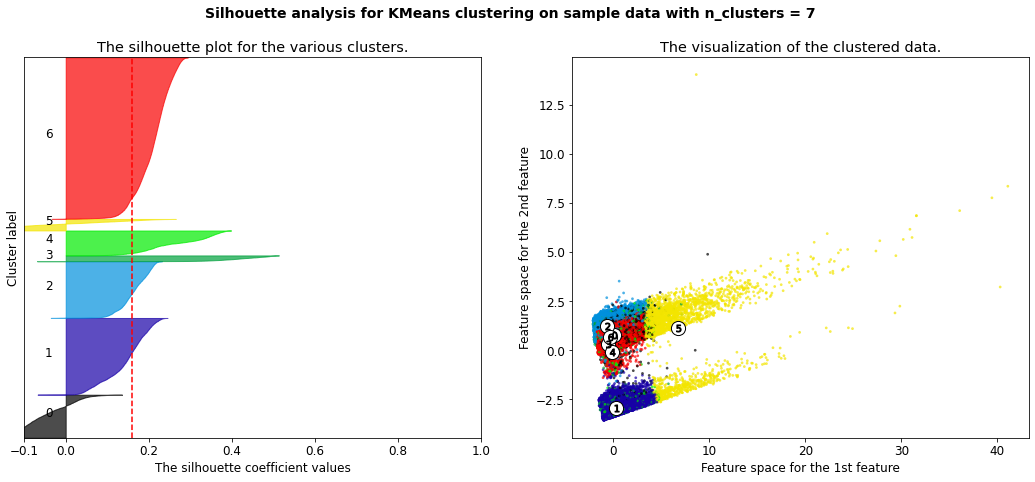

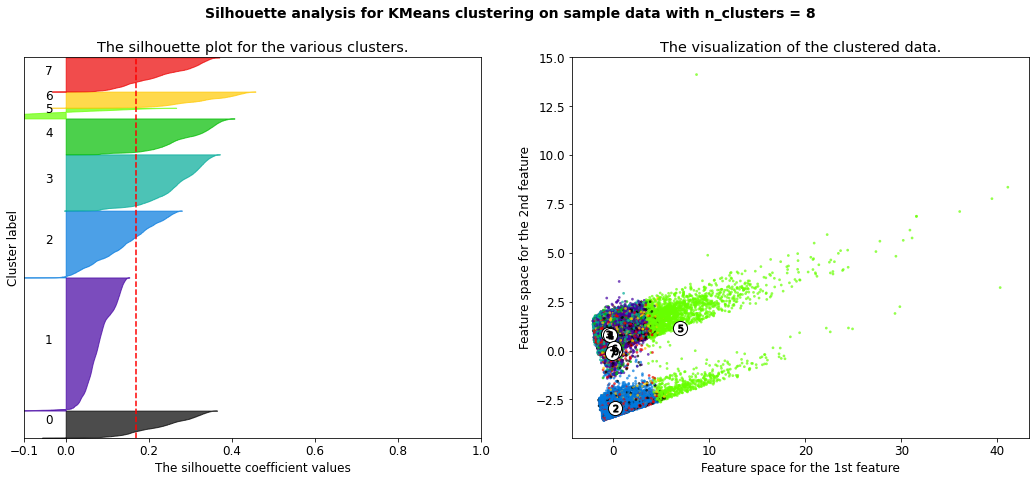

In [6]:
clusterAnalysis(X, range_n_clusters)

On constate :
* On obtient des cluster homogènes
* Le coefficient silhouette est faible proche de 0 ce qui signifie que les distances inter-cluster et intra-cluster sont similaires 

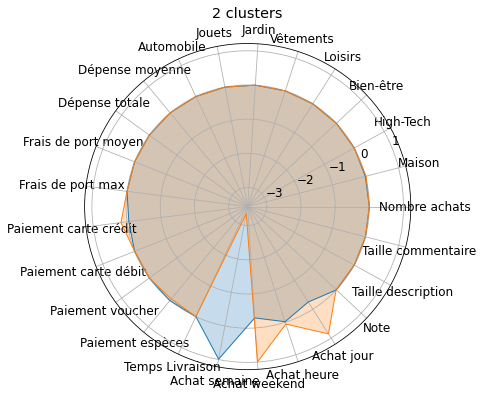

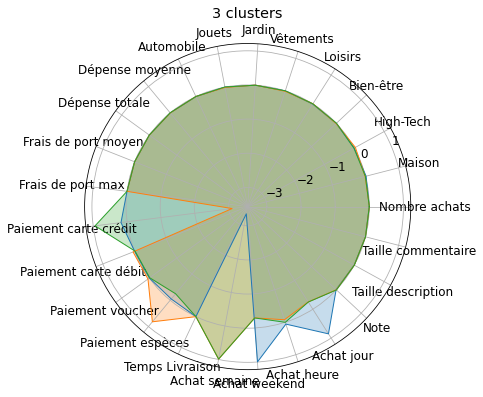

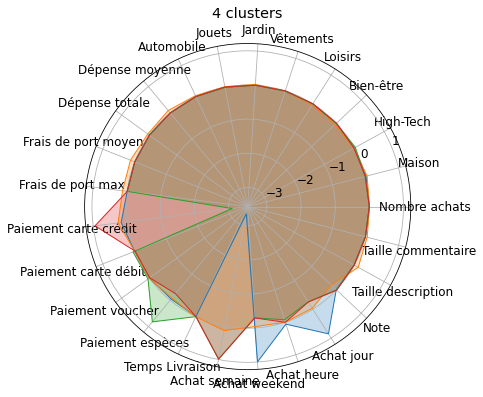

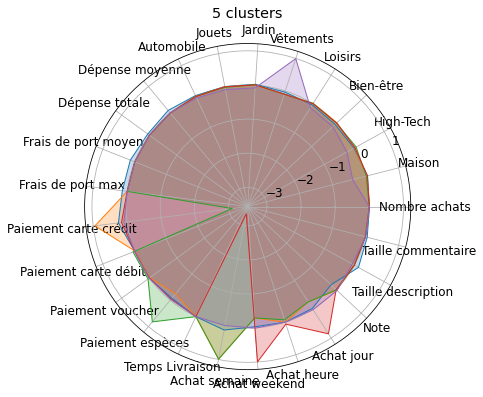

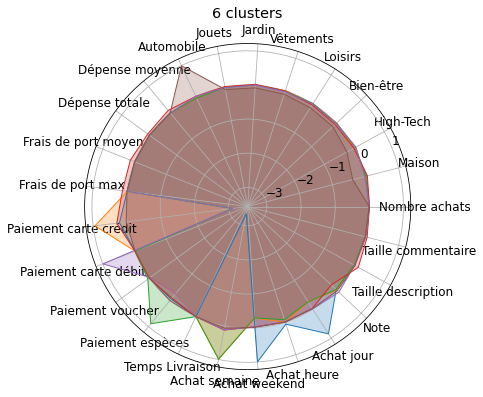

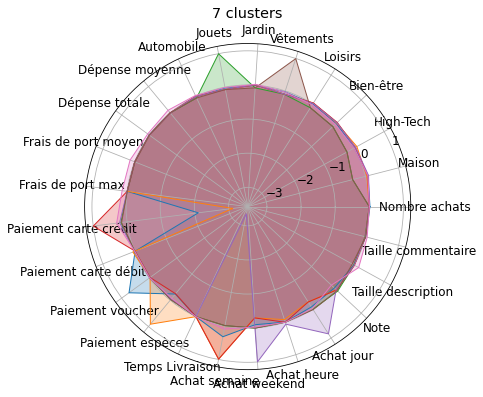

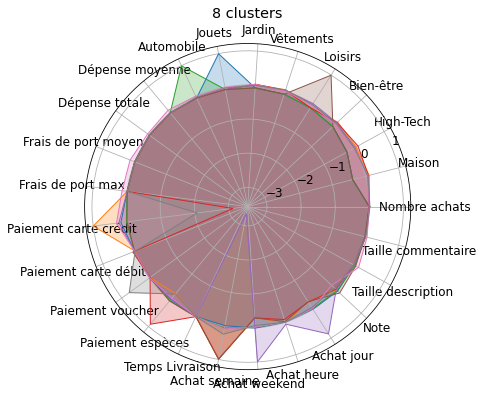

In [7]:
radarPlot(X, range_n_clusters)

On constate :
* beaucoup de variables varient peu entre les différents clusters
* difficile d'établir des profils de clients

On va donc sélectionner des variables selon un thème à étudier par exemple la satisfaction client.

### Satisfaction client

In [8]:
X = data.loc[:,['Note', 'Taille commentaire', 'Dépense moyenne', 'Temps Livraison', 'Taille description']]

For n_clusters = 2 The average silhouette_score is : 0.4071627695066258
For n_clusters = 3 The average silhouette_score is : 0.3996779614752735
For n_clusters = 4 The average silhouette_score is : 0.36822248427589954
For n_clusters = 5 The average silhouette_score is : 0.3743128629593549
For n_clusters = 6 The average silhouette_score is : 0.35862248717642
For n_clusters = 7 The average silhouette_score is : 0.3267137793446921
For n_clusters = 8 The average silhouette_score is : 0.3251703999736631


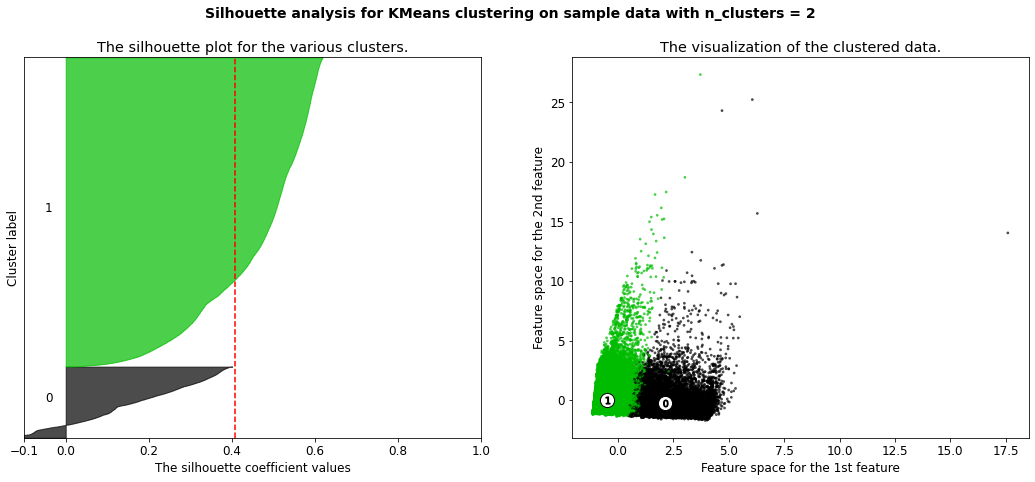

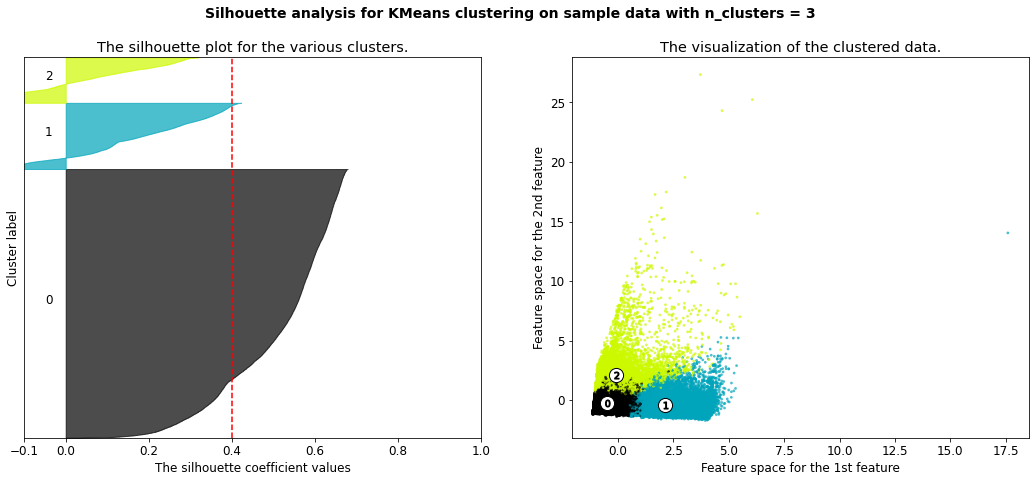

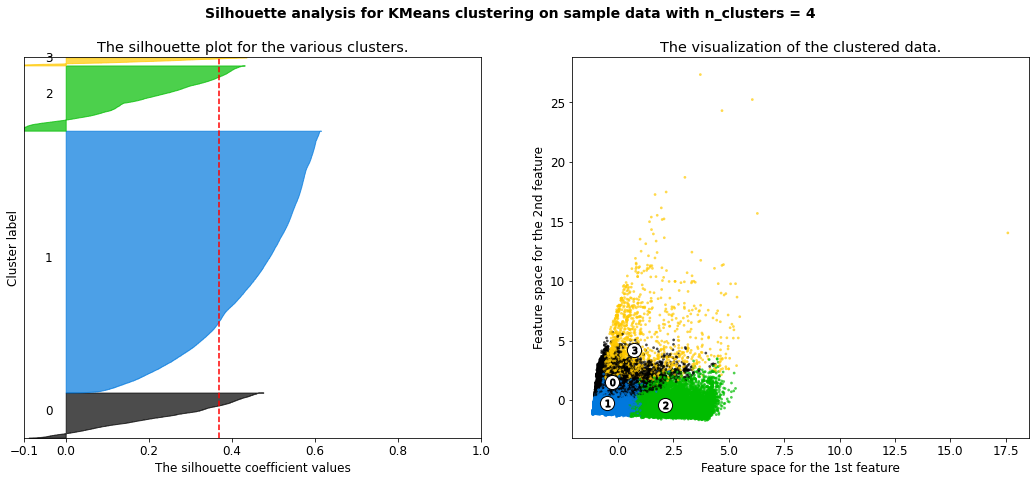

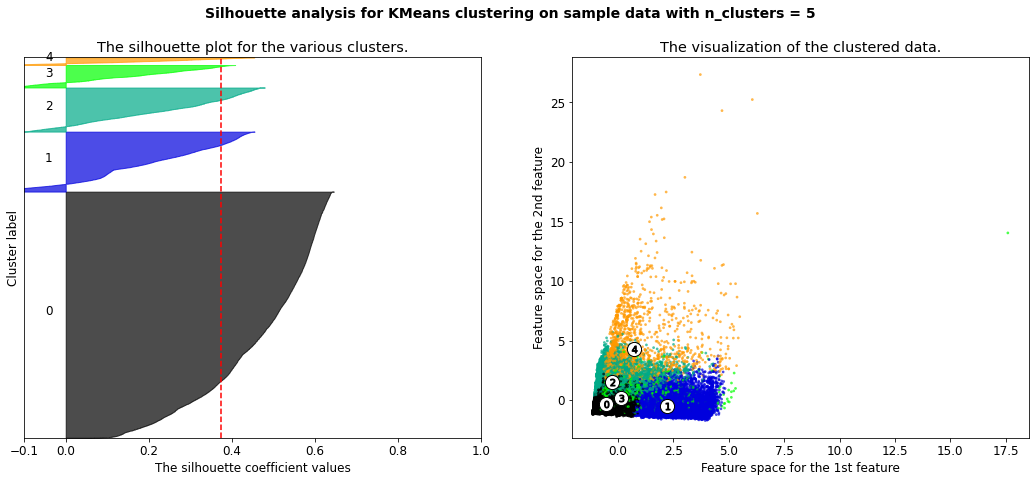

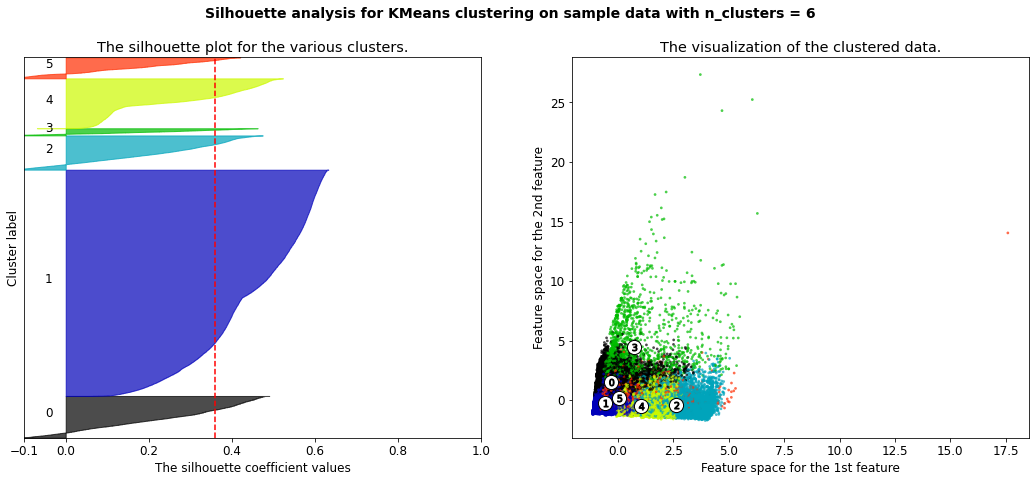

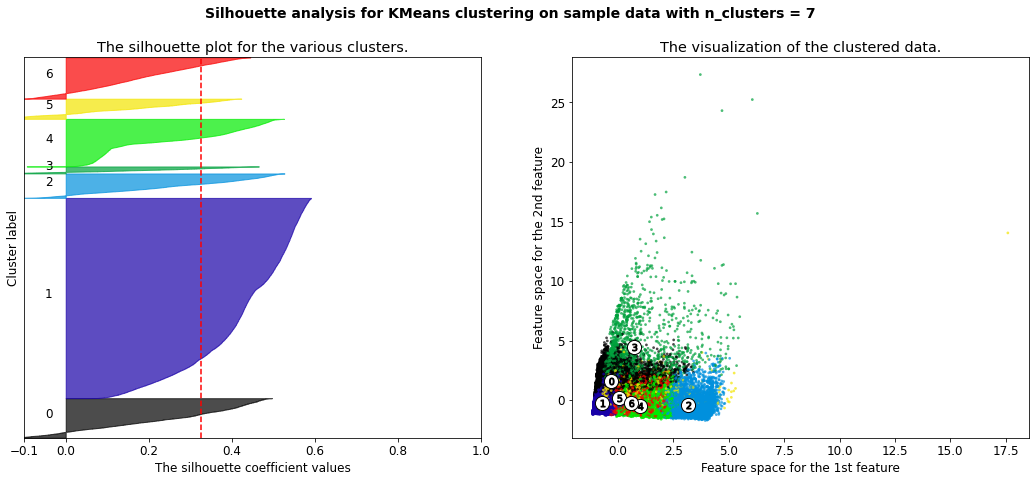

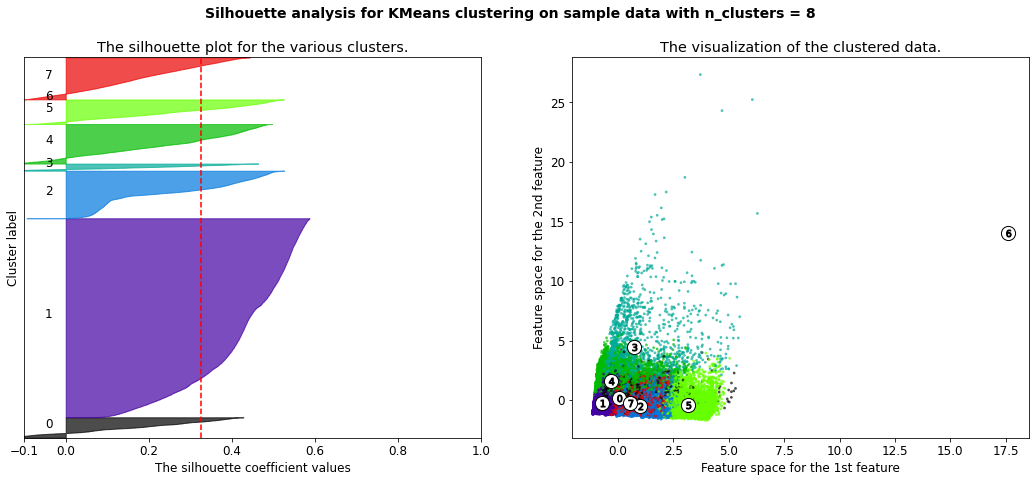

In [9]:
clusterAnalysis(X, range_n_clusters)

On constate :
* coefficient silhouette plus élevé proche de 0,4
* cluster moins homogène en général 1 cluster principal
* le score pour 5 cluster est plus élevé que les précédents

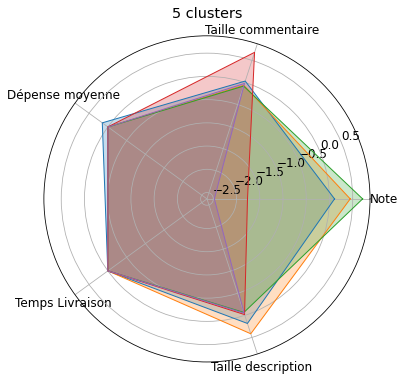

In [10]:
radarPlot(X, [5])

On constate :
* les clients qui donnent la moins bonne note mettent en général un plus long commentaire
* les clients qui donnent la moins bonne note le font sur des articles où la description est plus courte
* le temps de livraison et la dépense moyenne ne permettent pas d'expliquer les différents cluster pour l'algorithme

### Habitudes de paiement

On peut aussi étudier les habitudes des clients concernant l'achat.

In [11]:
X = data.loc[:,['Achat jour', 'Achat heure', 'Paiement carte crédit', 'Paiement carte débit', 'Paiement voucher', 'Paiement espèces', 'Dépense moyenne']]

For n_clusters = 2 The average silhouette_score is : 0.4719973753349495
For n_clusters = 3 The average silhouette_score is : 0.4807985668609688
For n_clusters = 4 The average silhouette_score is : 0.5020681602784858
For n_clusters = 5 The average silhouette_score is : 0.35483557424206225
For n_clusters = 6 The average silhouette_score is : 0.33578687943454677
For n_clusters = 7 The average silhouette_score is : 0.368804626008698
For n_clusters = 8 The average silhouette_score is : 0.35632204213867164


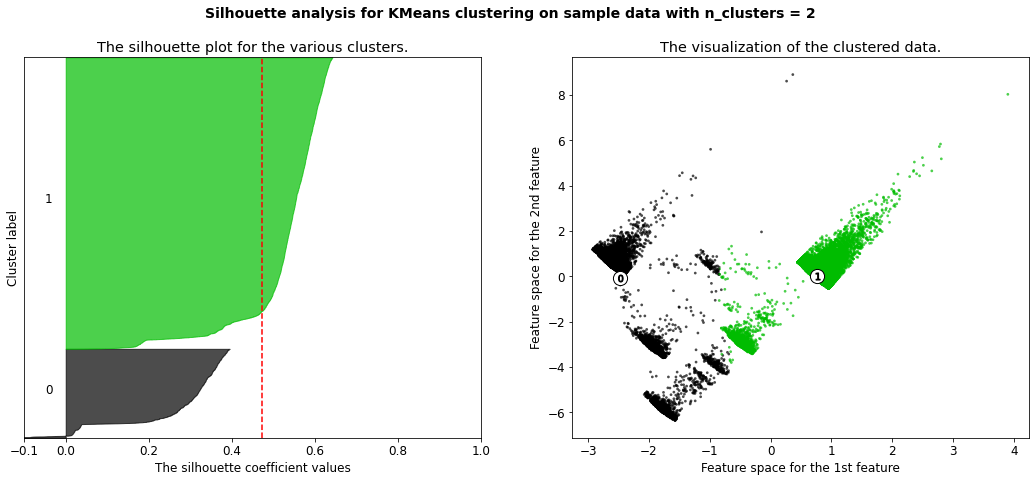

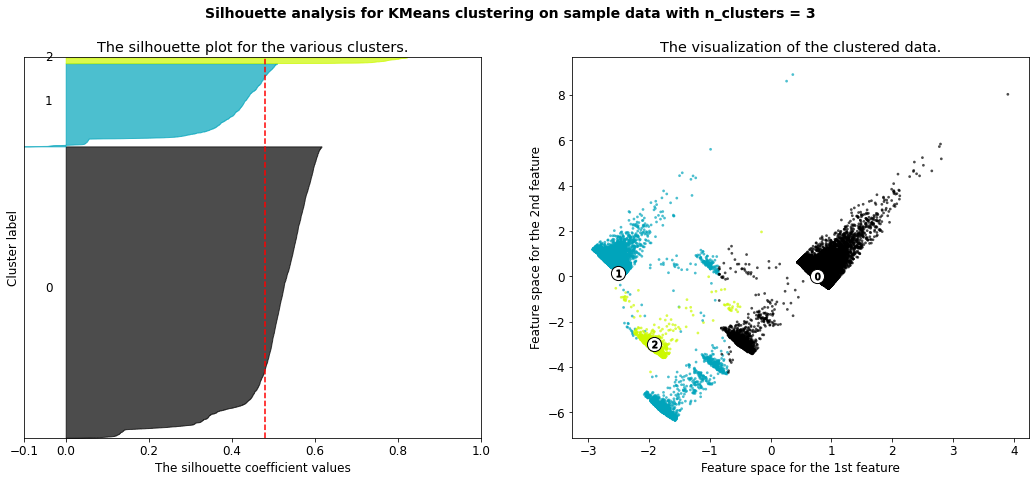

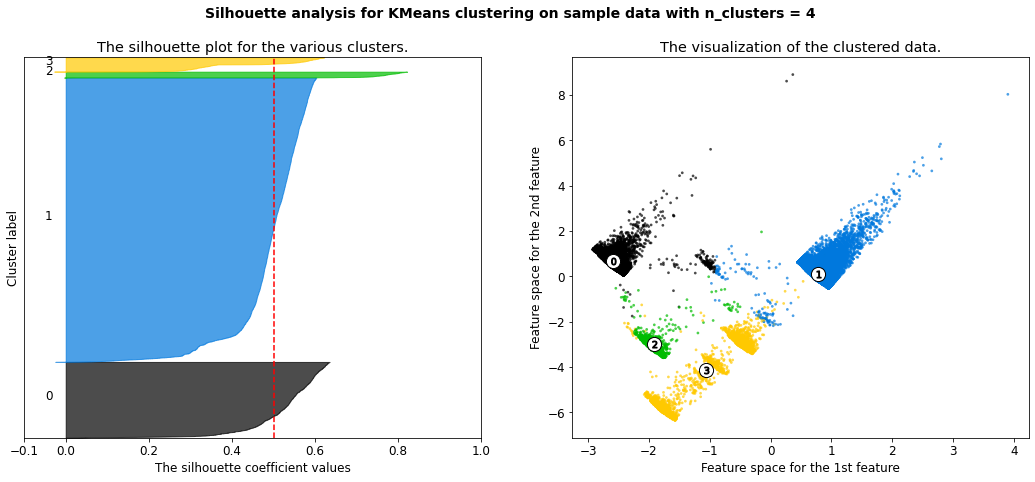

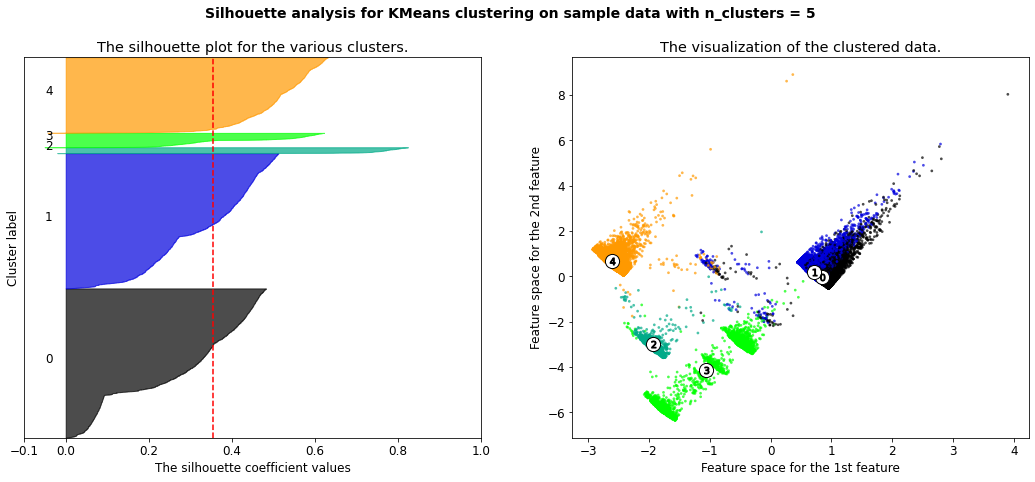

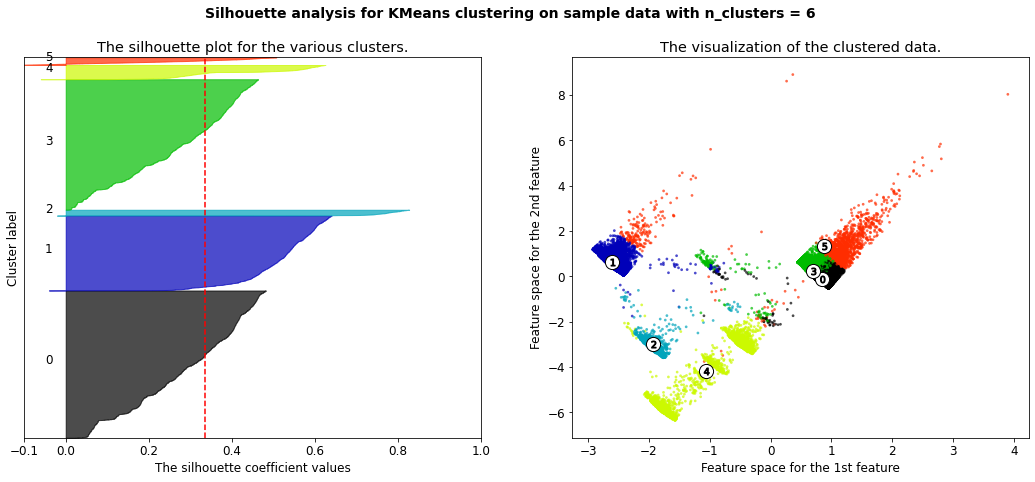

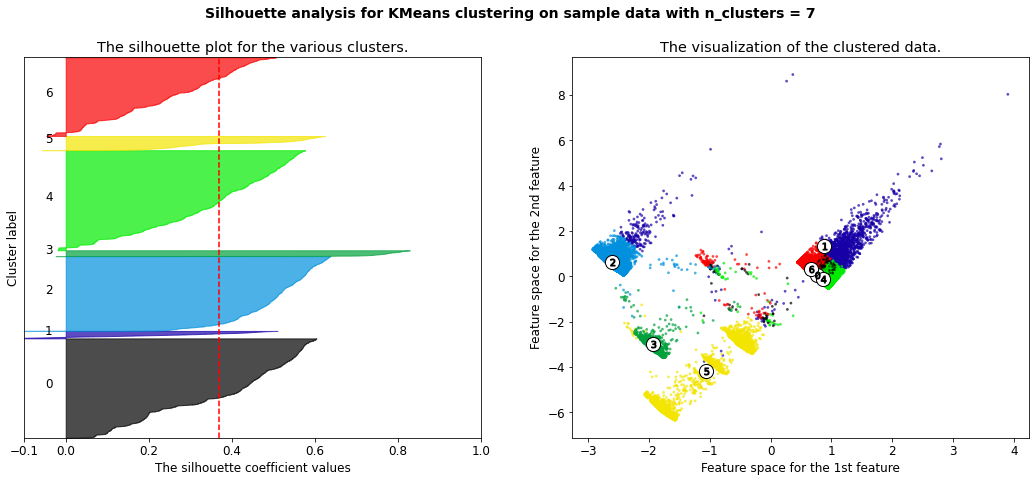

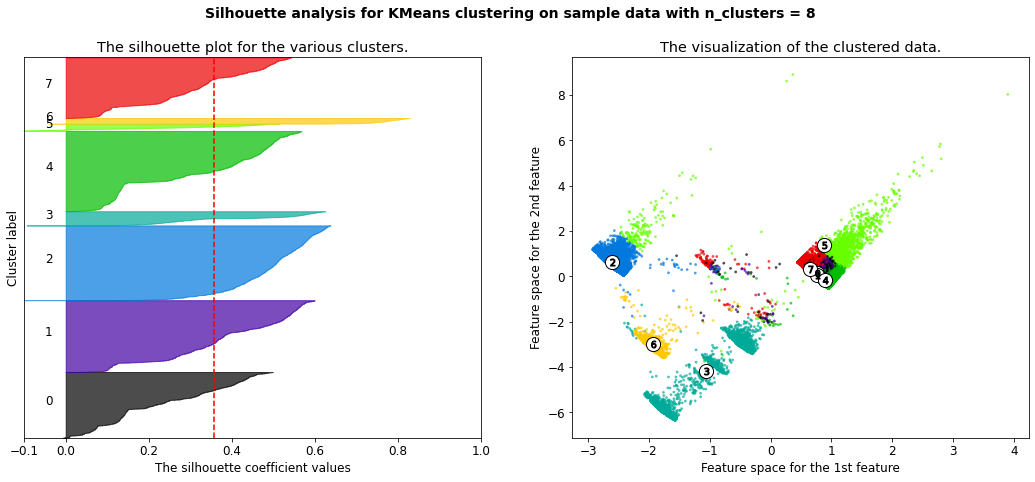

In [12]:
clusterAnalysis(X, range_n_clusters)

On constate :
* cluster peu homogènes
* coefficient silhouette proche de 0,5

Le meilleur score est obtenu pour 4 clusters

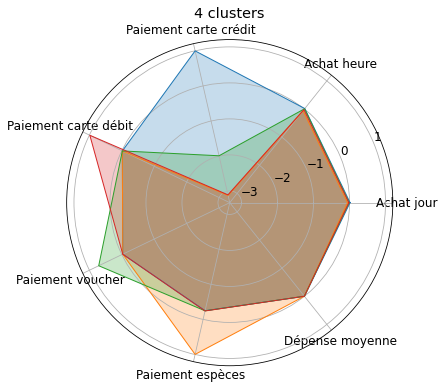

In [13]:
radarPlot(X, [4])

On constate :
* 4 clusters correspondent au différents types de paiement
* La dépense moyenne, le jour et l'heure d'achat ne permet pas d'apporter plus de variations. On peut donc dire que la dépense moyenne et le moment de l'achat ne semble pas influencer le type de paiement.

### Habitudes clients

On peut également étudier les différents types de produits achetés par les clients.

In [14]:
X = data.loc[:,['Maison', 'High-Tech', 'Bien-être', 'Loisirs', 'Vêtements', 'Jardin', 'Jouets', 'Automobile', 'Nombre achats', 'Achat jour']]

For n_clusters = 2 The average silhouette_score is : 0.16230328267055852
For n_clusters = 3 The average silhouette_score is : 0.2663171154093274
For n_clusters = 4 The average silhouette_score is : 0.35768224275719035
For n_clusters = 5 The average silhouette_score is : 0.4499210093218839
For n_clusters = 6 The average silhouette_score is : 0.5013408763027335
For n_clusters = 7 The average silhouette_score is : 0.5814275354299872
For n_clusters = 8 The average silhouette_score is : 0.6437473223096639


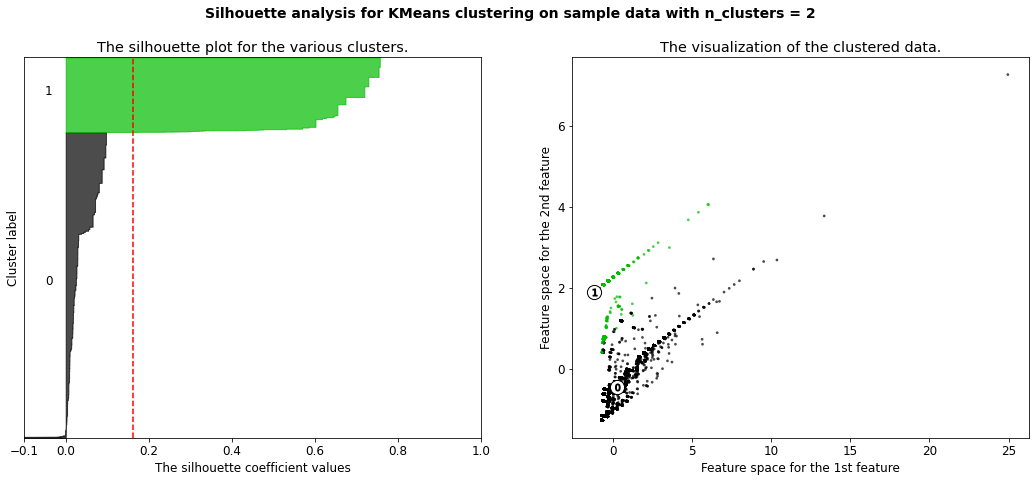

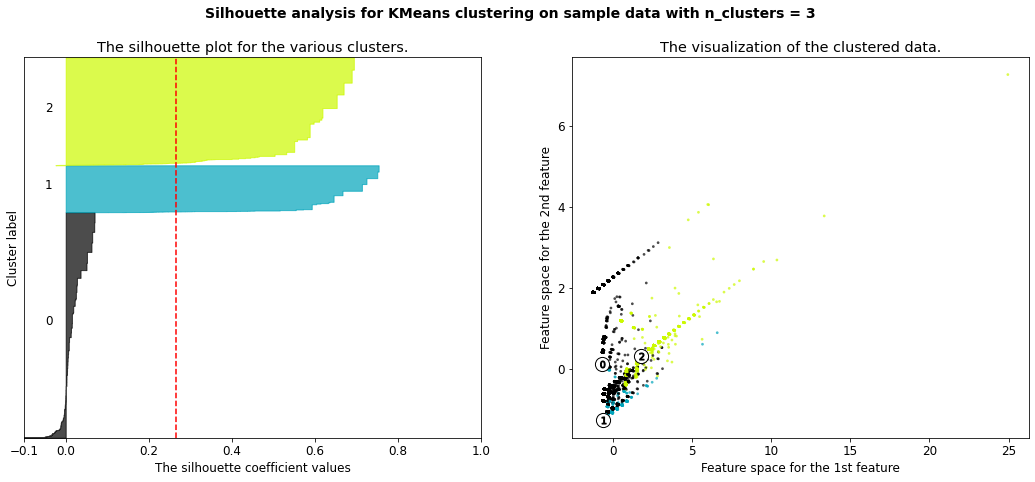

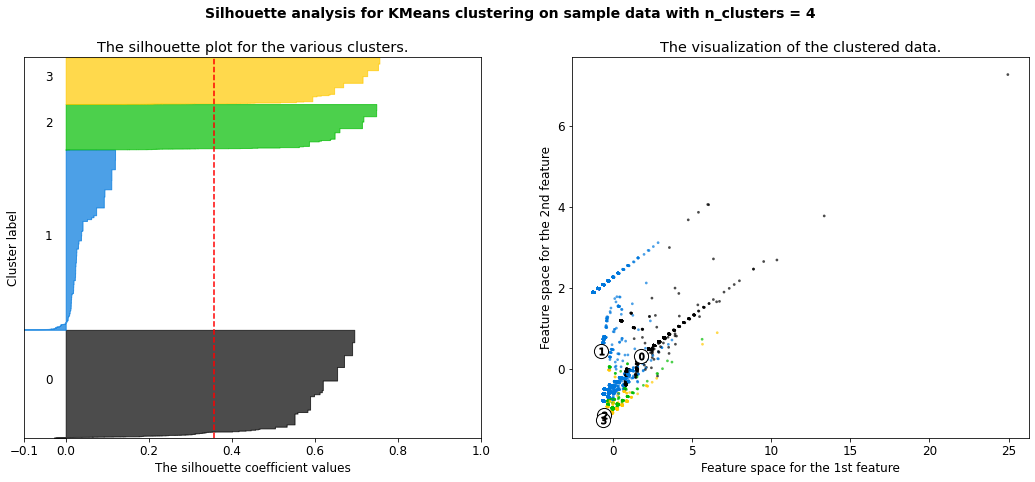

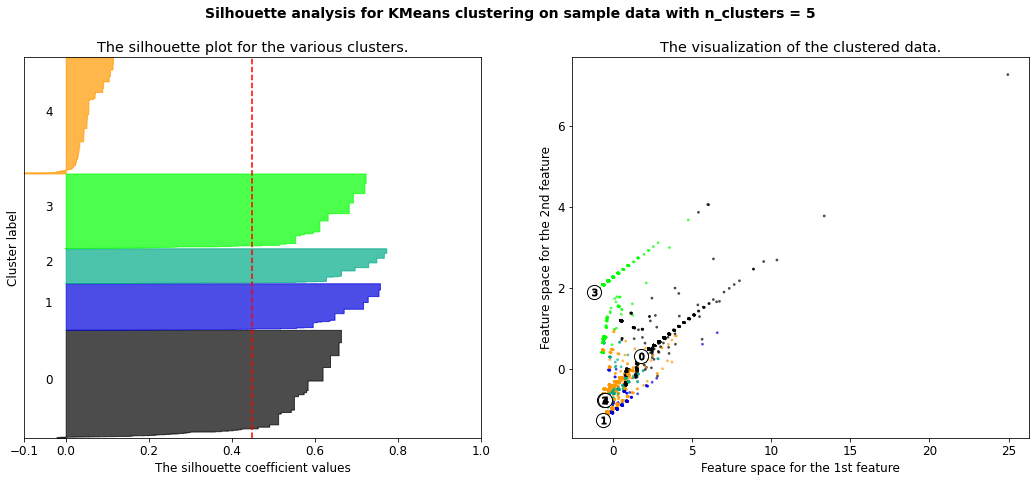

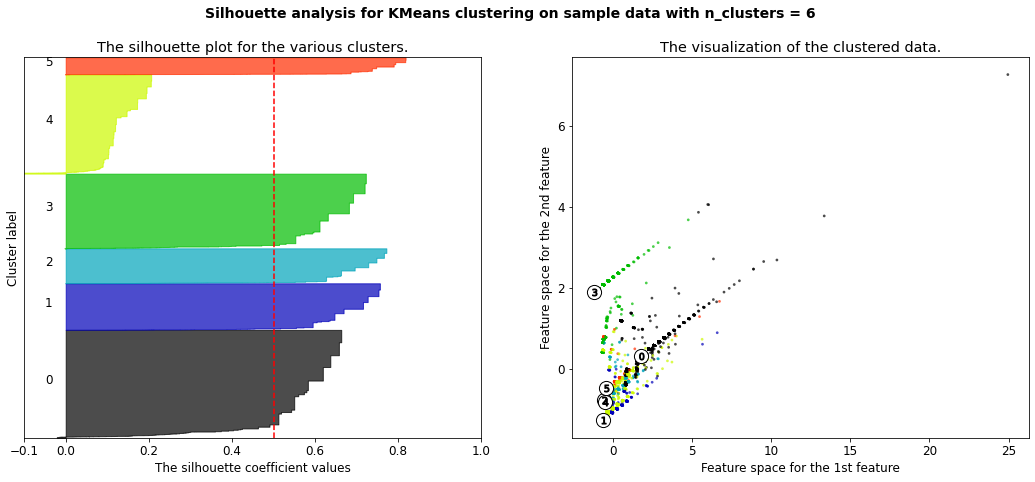

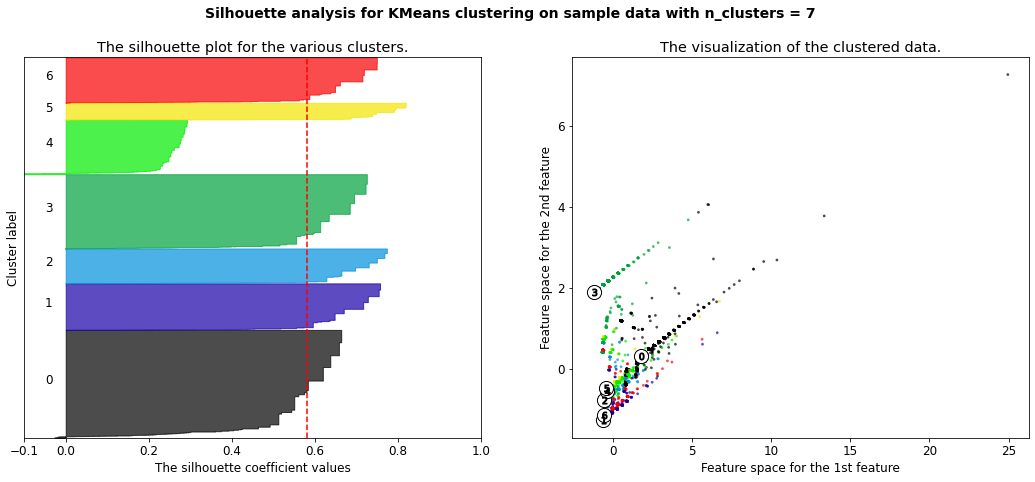

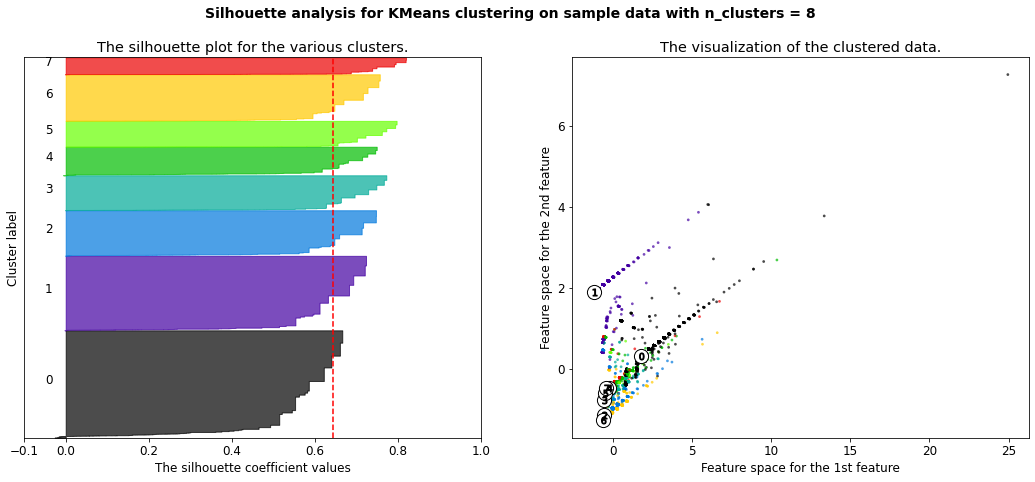

In [15]:
clusterAnalysis(X, range_n_clusters)

On constate :
* On obtient le meilleur score pour 8 clusters qui correspond au 8 groupes de catégories de produits définis 
* les clusters sont globalement homogènes

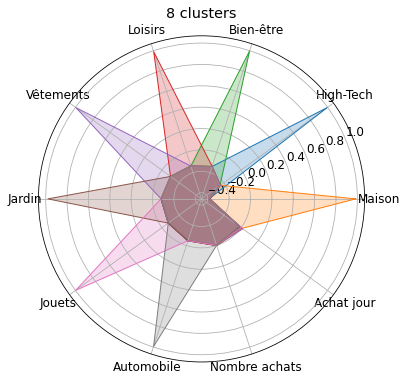

In [16]:
radarPlot(X, [8])

On constate :
* 8 clusters, un pour chaque type de produit
* Le nombre d'achat ainsi que le jour de l'achat ne semble pas avoir d'impact sur la segmentation

Maintenant que l'on dispose de modèles intéressants pour faire du clustering on peut étudier la question de la stabilité. Pour cela il est nécessaire d'utiliser un indicateur qui va permettre la comparaison entre deux segmentation.

### ARI : Adjusted Rand index

Afin de comparer 2 segmentation il existe une méthode intitulée Adjusted Rand Index (ARI). Le principe consiste à comparer des couples de points en regardant si ils ont été classé de la même manière sur les 2 segmentations. Cette méthode repose sur le Rand Index (RI). 

#### Rand Index (RI)
Il est calculé de la façon suivante :

$$\frac{A + B}{\binom{n}{2}} = \frac{\text{nb couple points même cluster  + nb couple points cluster différents}}{\text{nb couple de points}}$$

#### exemple : 

On dispose de 4 points : {a, b, c, d}

Le modèle 1 clustering : {0, 0, 1, 1}

Le modèle 2 clustering : {0, 1, 2, 2}

Il y a $\binom{4}{2} = 6 $ couples de points (a,b) (a,c) (a,d) (b,c) (b,d) (c,d)

A = 1 car seul (c,d) est dans le même cluster dans chaque modèle

B = 4 car (a,c) (a,d) (b,c) (b,d) sont dans des clusters différents dans chaque modèle

En revanche (a,b) est dans le même cluster pour le modèle 1 et dans des clusters différents pour le modèle 2

On a donc $ RI = \frac{5}{6}$

source intéressante https://davetang.org/muse/2017/09/21/adjusted-rand-index/

#### Adjusted Rand Index (ARI)
Il est calculé de la façon suivante :

$$ARI = \frac{\text{RI} - \mathbb{E}(\text{RI})}{\text{max(RI)} - \mathbb{E}(\text{RI})}$$

On utilise le score ARI plutôt que le score RI car lorsqu'il y a beaucoup de clusters il y a de grandes chances pour que deux points soient dans des clusters différents. Lorsque qu'il y a beaucoup de clusters le score ARI a tendence à être gonflé artificiellement.

### Stabilité à l'initialisation

In [19]:
ARI_list = []
X = data.loc[:,['Note', 'Taille commentaire', 'Dépense moyenne', 'Temps Livraison', 'Taille description']]

In [20]:
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

In [21]:
model_base = KMeans(n_clusters=5, random_state=42)
model_base.fit(X_scaled)
cluster_labels = model_base.labels_

In [22]:
for i in range(10):
    model_temp = KMeans(n_clusters=5)
    model_temp.fit(X_scaled)
    temp_labels = model_temp.labels_
    score = adjusted_rand_score(cluster_labels,temp_labels)
    ARI_list.append(score)

Text(0, 0.5, 'ARI score')

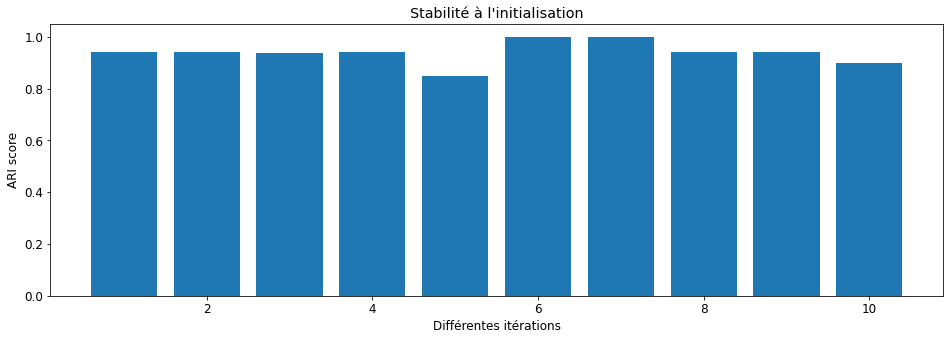

In [23]:
fig, ax = plt.subplots(figsize=(16,5))
ax.bar(range(1,len(ARI_list)+1), ARI_list)
ax.set_title('Stabilité à l\'initialisation')
ax.set_xlabel('Différentes itérations')
ax.set_ylabel('ARI score')

### Stabilité temporelle

Etudier la stabilité temporelle revient à suivre un groupe de client initial et voir si dans le temps ce groupe de clients change de cluster au fur et à mesure que de nouveaux clients sont ajoutés à la base de donnée. Pour cela nous avons besoin d'utiliser le dataframe des commandes et de regénérer celui des clients à chaque pas de temps

Lecture des fichiers

In [24]:
df_customers_dataset = pd.read_csv('data/olist_customers_dataset.csv', sep=',')
df_geolocation = pd.read_csv('data/olist_geolocation_dataset.csv', sep=',')
df_order_items = pd.read_csv('data/olist_order_items_dataset.csv', sep=',')
df_order_payments = pd.read_csv('data/olist_order_payments_dataset.csv', sep=',')
df_order_reviews = pd.read_csv('data/olist_order_reviews_dataset.csv', sep=',')
df_orders_dataset = pd.read_csv('data/olist_orders_dataset.csv', sep=',')
df_products_dataset = pd.read_csv('data/olist_products_dataset.csv', sep=',')
df_sellers_dataset = pd.read_csv('data/olist_sellers_dataset.csv', sep=',')
df_product_translation = pd.read_csv('data/product_category_name_translation.csv', sep=',')

Merge des dataframe

In [25]:
df = pd.merge(df_order_items, df_order_payments, on='order_id', how='outer')
df = pd.merge(df, df_order_reviews, on='order_id', how='outer')
df = pd.merge(df, df_orders_dataset, on='order_id', how='outer')
df = pd.merge(df, df_products_dataset, on='product_id', how='outer')
df = pd.merge(df, df_customers_dataset, on='customer_id', how='outer')
df = pd.merge(df, df_sellers_dataset, on='seller_id', how='outer')
df = pd.merge(df, df_product_translation, on='product_category_name', how='outer')

Nettoyage des données

In [26]:
df.loc[:,'review_comment_message'] = df.loc[:,'review_comment_message'].fillna('')
df = df.drop(axis='columns', columns='review_comment_title')
df = df.dropna()

Ajout de variables

In [27]:
category_dict = {
    'bed_bath_table'                              : 'Cuisine & Maison',
    'health_beauty'                               : 'Beauté, Santé et Bien-être',
    'sports_leisure'                              : 'Sport et Loisirs',
    'furniture_decor'                             : 'Cuisine & Maison',
    'computers_accessories'                       : 'High-Tech',
    'housewares'                                  : 'Cuisine & Maison',
    'watches_gifts'                               : 'Vêtements, Chaussures et Bijoux',
    'telephony'                                   : 'High-Tech',
    'garden_tools'                                : 'Bricolage, jardin et Animalerie',
    'auto'                                        : 'Automobile et Industrie',
    'toys'                                        : 'Jouets, enfants et bébés',
    'cool_stuff'                                  : 'High-Tech',
    'perfumery'                                   : 'Beauté, Santé et Bien-être',
    'baby'                                        : 'Jouets, enfants et bébés',
    'electronics'                                 : 'High-Tech',
    'stationery'                                  : 'Sport et Loisirs',
    'fashion_bags_accessories'                    : 'Vêtements, Chaussures et Bijoux',
    'pet_shop'                                    : 'Bricolage, jardin et Animalerie',
    'office_furniture'                            : 'Cuisine & Maison',
    'luggage_accessories'                         : 'Vêtements, Chaussures et Bijoux',
    'consoles_games'                              : 'High-Tech',
    'construction_tools_construction'             : 'Bricolage, jardin et Animalerie',
    'home_appliances'                             : 'Cuisine & Maison',
    'musical_instruments'                         : 'Sport et Loisirs',
    'small_appliances'                            : 'Cuisine & Maison',
    'home_construction'                           : 'Bricolage, jardin et Animalerie',
    'books_general_interest'                      : 'Sport et Loisirs',
    'furniture_living_room'                       : 'Cuisine & Maison',
    'food'                                        : 'Cuisine & Maison',
    'home_confort'                                : 'Cuisine & Maison',
    'audio'                                       : 'High-Tech',
    'drinks'                                      : 'Cuisine & Maison',
    'market_place'                                : 'Cuisine & Maison',
    'construction_tools_lights'                   : 'Bricolage, jardin et Animalerie',
    'air_conditioning'                            : 'Cuisine & Maison',
    'kitchen_dining_laundry_garden_furniture'     : 'Cuisine & Maison',
    'food_drink'                                  : 'Cuisine & Maison',
    'fashion_shoes'                               : 'Vêtements, Chaussures et Bijoux',
    'books_technical'                             : 'Sport et Loisirs',
    'industry_commerce_and_business'              : 'Automobile et Industrie',
    'home_appliances_2'                           : 'Cuisine & Maison',
    'fixed_telephony'                             : 'High-Tech',
    'agro_industry_and_commerce'                  : 'Automobile et Industrie',
    'costruction_tools_garden'                    : 'Bricolage, jardin et Animalerie',
    'computers'                                   : 'High-Tech',
    'art'                                         : 'Sport et Loisirs',
    'signaling_and_security'                      : 'Cuisine & Maison',
    'construction_tools_safety'                   : 'Bricolage, jardin et Animalerie',
    'christmas_supplies'                          : 'Cuisine & Maison',
    'fashion_underwear_beach'                     : 'Vêtements, Chaussures et Bijoux',
    'fashion_male_clothing'                       : 'Vêtements, Chaussures et Bijoux',
    'furniture_bedroom'                           : 'Cuisine & Maison',
    'costruction_tools_tools'                     : 'Bricolage, jardin et Animalerie',
    'tablets_printing_image'                      : 'High-Tech',
    'small_appliances_home_oven_and_coffee'       : 'Cuisine & Maison',
    'cine_photo'                                  : 'High-Tech',
    'dvds_blu_ray'                                : 'High-Tech',
    'books_imported'                              : 'Sport et Loisirs',
    'fashio_female_clothing'                      : 'Vêtements, Chaussures et Bijoux',
    'party_supplies'                              : 'Cuisine & Maison',
    'furniture_mattress_and_upholstery'           : 'Cuisine & Maison',
    'music'                                       : 'Sport et Loisirs',
    'diapers_and_hygiene'                         : 'Beauté, Santé et Bien-être',
    'flowers'                                     : 'Bricolage, jardin et Animalerie',
    'home_comfort_2'                              : 'Cuisine & Maison',
    'fashion_sport'                               : 'Vêtements, Chaussures et Bijoux',
    'arts_and_craftmanship'                       : 'Cuisine & Maison',
    'la_cuisine'                                  : 'Cuisine & Maison',
    'cds_dvds_musicals'                           : 'Sport et Loisirs',
    'fashion_childrens_clothes'                   : 'Vêtements, Chaussures et Bijoux',
    'security_and_services'                       : 'Cuisine & Maison'
}


In [28]:
df['category'] = df['product_category_name_english'].apply(lambda x: category_dict[x])
df['shipping_limit_date'] = pd.to_datetime(df['shipping_limit_date'])
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['temps livraison'] = df['shipping_limit_date'] - df['order_purchase_timestamp']
df['temps livraison'] = df['temps livraison'].apply(lambda x:x.days)
df['achat heure'] = df['order_purchase_timestamp'].apply(lambda x:x.hour)
df['dayofweek'] = df['order_purchase_timestamp'].apply(lambda x:x.dayofweek)
df['comment_length'] = df['review_comment_message'].apply(lambda x: len(x))

In [29]:
df = df.set_index('order_purchase_timestamp', drop=False)
df = df.sort_index()

In [30]:
def dataframeClient(df):
    X = pd.DataFrame()
    df_group = df.groupby('customer_unique_id')

    X['Nombre achats'] = df_group.size()
    X['Maison'] = df_group['category'].apply(lambda x: (x=='Cuisine & Maison').sum()/x.shape[0])
    X['High-Tech'] = df_group['category'].apply(lambda x: (x=='High-Tech').sum()/x.shape[0])
    X['Bien-être'] = df_group['category'].apply(lambda x: (x=='Beauté, Santé et Bien-être').sum()/x.shape[0])
    X['Loisirs'] = df_group['category'].apply(lambda x: (x=='Sport et Loisirs').sum()/x.shape[0])
    X['Vêtements'] = df_group['category'].apply(lambda x: (x=='Vêtements, Chaussures et Bijoux').sum()/x.shape[0])
    X['Jardin'] = df_group['category'].apply(lambda x: (x=='Bricolage, jardin et Animalerie').sum()/x.shape[0])
    X['Jouets'] = df_group['category'].apply(lambda x: (x=='Jouets, enfants et bébés').sum()/x.shape[0])
    X['Automobile'] = df_group['category'].apply(lambda x: (x=='Automobile et Industrie').sum()/x.shape[0])

    X['Dépense moyenne'] = df_group['price'].mean()
    X['Dépense totale'] = df_group['price'].sum()
    X['Frais de port moyen'] = df_group['freight_value'].mean()
    X['Frais de port max'] = df_group['freight_value'].max()

    X['Paiement carte crédit'] = df_group['payment_type'].apply(lambda x: (x=='credit_card').sum()/x.shape[0])
    X['Paiement carte débit'] = df_group['payment_type'].apply(lambda x: (x=='debit_card').sum()/x.shape[0])
    X['Paiement voucher'] = df_group['payment_type'].apply(lambda x: (x=='voucher').sum()/x.shape[0])
    X['Paiement espèces'] = df_group['payment_type'].apply(lambda x: (x=='boleto').sum()/x.shape[0])

    X['Temps Livraison'] = df_group['temps livraison'].mean()

    X['Achat semaine'] = df_group['dayofweek'].apply(lambda x: (x <= 4).sum()/x.shape[0])
    X['Achat weekend'] = df_group['dayofweek'].apply(lambda x: (x > 4).sum()/x.shape[0])
    X['Achat heure'] = df_group['achat heure'].apply(lambda x:x.mode()[0])
    X['Achat jour'] = df_group['dayofweek'].apply(lambda x:x.mode()[0])

    X['Note'] = df_group['review_score'].mean()

    X['Taille description'] = df_group['product_description_lenght'].mean()
    X['Taille commentaire'] = df_group['comment_length'].mean()
    
    return X

In [31]:
import datetime
from pandas.tseries.offsets import DateOffset

start_date = datetime.datetime(2017,1,1,0,0,0)
end_date = datetime.datetime(2018,1,1,0,0,0)

In [32]:
ARI_list = []
df_base = df.loc[start_date:end_date,:]
X = dataframeClient(df_base)
customer_base = X.index
X = X.loc[:,['Note', 'Taille commentaire', 'Dépense moyenne', 'Temps Livraison', 'Taille description']]

scaler = RobustScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

model_base = KMeans(n_clusters=5, random_state=42)
model_base.fit(X_scaled)
labels_base = model_base.labels_


for i in range(1,11):
    temp_date = end_date + DateOffset(months=i)
    df_temp = df.loc[start_date:temp_date,:]
    X_temp = dataframeClient(df_temp)
    print(X_temp.shape)
    X_temp = X_temp.loc[:,['Note', 'Taille commentaire', 'Dépense moyenne', 'Temps Livraison', 'Taille description']]
    scaler = RobustScaler()
    scaler.fit(X_temp)
    X_temp_scaled = scaler.transform(X_temp)
    
    model_temp = KMeans(n_clusters=5, random_state=42)
    model_temp.fit(X_temp_scaled)
    X_temp.loc[:,'labels'] = model_temp.labels_
    
    labels_temp = X_temp.loc[customer_base,'labels'].values
    ARI_score = adjusted_rand_score(labels_base,labels_temp)
    ARI_list.append(ARI_score)

(48082, 25)
(54273, 25)
(60936, 25)
(67454, 25)
(73928, 25)
(79785, 25)
(85687, 25)
(91806, 25)
(91806, 25)
(91806, 25)


1 an de données à l'initialisation

Text(0, 0.5, 'ARI score')

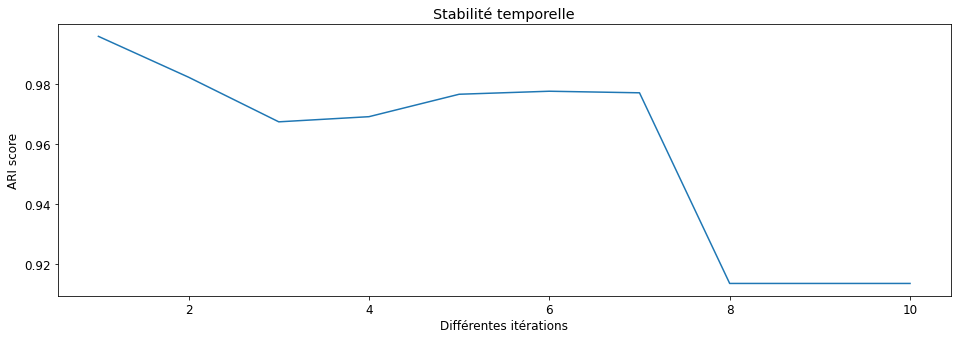

In [34]:
fig, ax = plt.subplots(figsize=(16,5))
ax.plot(range(1,len(ARI_list)+1), ARI_list)
ax.set_title('Stabilité temporelle')
ax.set_xlabel('Différentes itérations')
ax.set_ylabel('ARI score')

On constate que le modèle relativement stable dans le temps même après 10 mois. Cela signifie que les nouveaux clients arrivés au cours des dix derniers mois n'ont pas significativement changé l'organisation des clusters. Cela est évidemment dépendant des variables étudiées, certaines variables sont relativement stables dans le temps.